In [2]:
import argparse

import pickle
import os,sys
import numpy as np
import xgboost, os
import pandas as pd
import pickle
import sklearn
from sklearn.model_selection import StratifiedShuffleSplit
import utils
from Classifier import GeneralizedFuzzyEvolveClassifier

/home/chloezh/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

In [4]:
n_bucket = 4
evolve_type = 'RNN'
hold_off = 180
observation = 360
visit_type = 'bucket'
data_type = 'regular'
out_root = 'outputs'
unique_id = f'Dynamic_FNN_{n_bucket}_{visit_type}_hold_off_{hold_off}_{evolve_type}'
random_state = 1234

In [5]:
dataset_root = '/nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Code/Yufeng/FNN_evolve/dataset'
ffile_root = os.path.join(dataset_root,f'{visit_type}_based/UMHS_lab_vital_{n_bucket}_{visit_type}s_h_{hold_off}_o_{observation}.p')
dataset = pickle.load(open(ffile_root,'rb'))

In [29]:
if data_type == 'regular':
    data = np.array(dataset['variables'])
    labels = np.array(dataset['response'])
elif data_type == 'intersection':
    full_data = dataset['full_data']
    intersectionID = np.load('intersection_PatientID.npy')
    intersectionID = set(intersectionID)
    all_df = full_data[full_data['PATIENT_ID'].isin(intersectionID)]
    data = np.array(all_df.iloc[:,2:-1])
    labels = np.array(all_df.iloc[:,-1].apply(lambda x: utils.convert_label_to_int(x)))

rule_data = None
split_method = 'sample_wise'
category_info = dataset['category_info']
num_classes = dataset['num_classes']
feature_names = dataset.get('feature_names')
static_feature_names = ['diabetes',
                    'hypertension',
                    'renalfailure',
                    'obesity',
                    'copd',
                    'anemia',
                    'sleepdisorder',
                    'Heart_History',
                    'Smoker',
                    'Alcohol',
                    'Drug',
                    'CURR_AGE_OR_AGE_DEATH',
                    'SEX']


num_time_varying_features = len(feature_names)
num_time_invariant_features = len(static_feature_names)
static_category_info = np.zeros(num_time_invariant_features) + 2
static_category_info[-2] = 0
static_category_info = static_category_info.astype(np.int32)

time_varying_features = data[:,0:num_time_varying_features*n_bucket]
time_invariant_features = data[:,-num_time_invariant_features:]

report_freq = 50
patience_step = 500
max_steps = 800

# split into training and testing
ss_train_test = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=random_state)
X, y, X_test,y_test = utils.split_dataset(ss_train_test, data, labels, index=0)
X_test = utils.fill_in_missing_value(X_test,X_test)
X_test_variant,X_test_invariant = utils.handle_data(X_test,num_time_invariant_features,n_bucket)

In [72]:
X = utils.fill_in_missing_value(X,X)
X_variant,X_invariant = utils.handle_data(X,num_time_invariant_features,n_bucket)

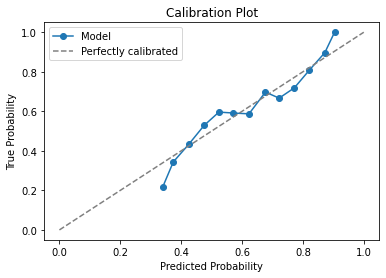

In [45]:
model_path = './models/Dynamic_FNN_4_bucket_hold_off_180_RNN/model.mdl'
clf = pickle.load(open(model_path, "rb"))

# Get predicted probabilities on the test set
probabilities = clf.predict_proba(X_test_variant,X_test_invariant)[:, 1]

# Compute true probabilities and mean predicted values
true_probs, predicted_probs = calibration_curve(y_test, probabilities, n_bins=20)

# Plot the calibration curve
plt.plot(predicted_probs, true_probs, marker='o', linestyle='-', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Plot')
plt.legend()
plt.show()

In [50]:
from sklearn.metrics import brier_score_loss
from sklearn.isotonic import IsotonicRegression

In [53]:
brier_score = brier_score_loss(y_test, probabilities)
print(np.round(brier_score,3))
# Calibrate the probabilities using isotonic regression
calibrator = IsotonicRegression()
calibrated_probabilities = calibrator.fit_transform(probabilities, y_test)

# Compute Brier score to assess calibration quality
brier_score = brier_score_loss(y_test, calibrated_probabilities)
print("Brier Score:", np.round(brier_score,3))

0.226
Brier Score: 0.221


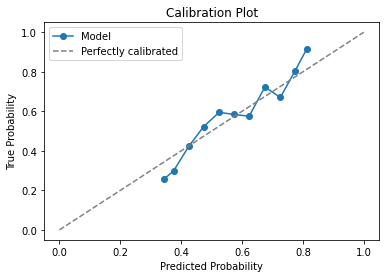

In [87]:
# platt scaling does not work
from sklearn.linear_model import LogisticRegression
platt_scaler = LogisticRegression()
probabilities = clf.predict_proba(X_test_variant,X_test_invariant)[:, 1]
platt_scaler.fit(probabilities.reshape(-1, 1), y_test)
calibrated_probs = platt_scaler.predict_proba(probabilities.reshape(-1, 1))[:, 1]
true_probs, predicted_probs = calibration_curve(y_test, calibrated_probs, n_bins=20)
plt.plot(predicted_probs, true_probs, marker='o', linestyle='-', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Plot')
plt.legend()
plt.show()

# Error Analysis

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [ ]:
# We sampled 100 patients each from false negatives (FNs), false positives (FPs), true positives (TPs), and true negatives (TNs)

In [89]:
test_metrics = utils.cal_metrics(clf,X_test_variant,X_test_invariant,y_test)

acc:0.628889; pre :0.6564; recall:0.6261; spec:0.6321; auc:0.6800; auprc: 0.6906; f1 : 0.7133


In [113]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
y_prob = clf.predict_proba(X_test_variant,X_test_invariant)
# fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:,1])
threshold = 0.5 # Change this value to adjust the threshold

# Convert probabilities to binary predictions based on the threshold
y_pred = (y_prob[:, 1] > threshold).astype(int)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract the values from the confusion matrix
true_negatives = conf_matrix[0, 0]
false_positives = conf_matrix[0, 1]
false_negatives = conf_matrix[1, 0]
true_positives = conf_matrix[1, 1]

# Calculate false positive rate (FPR) and false negative rate (FNR)
fpr = false_positives / (false_positives + true_negatives)
fnr = false_negatives / (false_negatives + true_positives)

print("False Positive Rate (FPR):", fpr)
print("False Negative Rate (FNR):", fnr)

False Positive Rate (FPR): 0.36477987421383645
False Negative Rate (FNR): 0.3753501400560224


In [116]:
import seaborn as sns

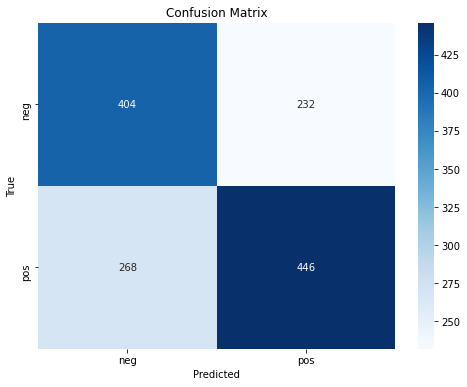

In [117]:
class_labels = ['neg', 'pos']  # Replace with your actual class labels

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [139]:
FN_indices = np.where((y_test == 1) & (y_pred == 0))[0]
FP_indices = np.where((y_test == 0) & (y_pred == 1))[0]
TN_indices = np.where((y_test == 0) & (y_pred == 0))[0]
TP_indices = np.where((y_test == 1) & (y_pred == 1))[0]

In [140]:
full_data = dataset['full_data']

In [128]:
index = list(ss_train_test.split(data, labels))[0]
train_index = index[0]
test_index = index[1]

In [134]:
test_df = full_data.iloc[test_index,:]

In [141]:
test_df_FN = test_df.iloc[FN_indices,:]
test_df_FP = test_df.iloc[FP_indices,:]
test_df_TN = test_df.iloc[TN_indices,:]
test_df_TP = test_df.iloc[TP_indices,:]

In [ ]:
static_feature_names = ['diabetes',
                        'hypertension',
                        'renalfailure',
                        'obesity',
                        'copd',
                        'anemia',
                        'sleepdisorder',
                        'Heart_History',
                        'Smoker',
                        'Alcohol',
                        'Drug',
                        'CURR_AGE_OR_AGE_DEATH',
                        'SEX']

In [164]:
row_list = []
for i in static_feature_names:
    TN = np.round(test_df_TN[i].mean(),4)
    FN = np.round(test_df_FN[i].mean(),4)
    TP = np.round(test_df_TP[i].mean(),4)
    FP = np.round(test_df_FP[i].mean(),4)
    stats = [TN,FN,TP,FP]
    row_list.append(stats)


In [165]:
static_error_stats  = pd.DataFrame(row_list,index = static_feature_names, columns = ['TN','FN','TP','FP'])

In [166]:
static_error_stats

,TN,FN,TP,FP
diabetes,0.2525,0.3507,0.7444,0.6897
hypertension,0.2574,0.3209,0.5874,0.5647
renalfailure,0.1287,0.1791,0.3767,0.3578
obesity,0.1832,0.1642,0.3004,0.3405
copd,0.0446,0.0672,0.3004,0.2543
anemia,0.2178,0.2873,0.6637,0.5388
sleepdisorder,0.0025,0.0000,0.6883,0.6336
Heart_History,0.2153,0.2985,0.3094,0.3147
Smoker,0.4455,0.4241,0.4871,0.4871
Alcohol,0.5173,0.4786,0.5738,0.6250


In [175]:
row_list = []
for i in feature_names:
    f = i + '_4'
    TN = np.round(test_df_TN[f].mean(),4)
    FN = np.round(test_df_FN[f].mean(),4)
    TP = np.round(test_df_TP[f].mean(),4)
    FP = np.round(test_df_FP[f].mean(),4)
    stats = [TN,FN,TP,FP]
    row_list.append(stats)
time_4_error_stats  = pd.DataFrame(row_list,index = feature_names, columns = ['TN','FN','TP','FP'])

In [177]:
time_4_error_stats

,TN,FN,TP,FP
ALB,4.1863,4.0857,4.0569,4.1177
ALP,90.0604,104.9868,113.4358,96.0265
ALT,32.5824,34.7339,34.9574,33.1138
AST,32.2070,35.9161,35.1615,32.6983
CO2,27.2258,27.1138,26.7562,26.7795
Calcium,9.3966,9.3369,9.2813,9.3282
Chloride,105.1196,105.0953,105.5119,105.3206
Glucose,103.4401,109.6246,119.8791,113.7116
Hematocrit,39.6760,37.8554,37.1493,38.1458
Lymphocyte,98.9698,20.6415,26.7043,34.9174


In [178]:
row_list = []
for i in feature_names:
    f = i + '_3'
    TN = np.round(test_df_TN[f].mean(),4)
    FN = np.round(test_df_FN[f].mean(),4)
    TP = np.round(test_df_TP[f].mean(),4)
    FP = np.round(test_df_FP[f].mean(),4)
    stats = [TN,FN,TP,FP]
    row_list.append(stats)
time_3_error_stats  = pd.DataFrame(row_list,index = feature_names, columns = ['TN','FN','TP','FP'])
time_3_error_stats

,TN,FN,TP,FP
ALB,4.2095,4.1188,4.0493,4.1137
ALP,88.8490,104.2608,113.3796,97.6737
ALT,32.7958,35.6225,34.3729,35.1734
AST,30.7759,35.4086,34.0837,32.8191
CO2,27.0681,27.1790,26.7010,26.7943
Calcium,9.4091,9.3595,9.2517,9.3515
Chloride,105.0298,105.1966,105.3150,105.2366
Glucose,105.2991,109.3228,118.9529,114.2979
Hematocrit,39.7059,38.2372,37.2354,38.0956
Lymphocyte,132.9114,27.4094,23.8316,36.7063


## check the icd code for those misclassified patients

In [180]:
icd_root = '/nfs/turbo/med-kayvan-lab/Datasets/Toyota/umhs/Processed'
ICD_tbl = pd.read_csv(os.path.join(icd_root,'HPI8298_Cases_QualifyingDx_DEID_v2.csv'))

In [204]:
TN_pat = test_df_TN['PATIENT_ID']
TP_pat = test_df_TP['PATIENT_ID']
FN_pat = test_df_FN['PATIENT_ID']
FP_pat = test_df_FP['PATIENT_ID']
TP_pat = pd.merge(TP_pat,ICD_tbl,on = 'PATIENT_ID',how = 'left')
FN_pat = pd.merge(FN_pat,ICD_tbl,on = 'PATIENT_ID',how = 'left')

In [211]:
TP_pat['DX_main'] = TP_pat['ICD_CODE'].apply(lambda x: x.split('.')[0])
FN_pat['DX_main'] = FN_pat['ICD_CODE'].apply(lambda x: x.split('.')[0])

In [234]:
FN_pat[((FN_pat.DX_main == 'I51') & (FN_pat.DX_CATEGORY == 'PSL'))].head(40)

,PATIENT_ID,VISIT_ID,QUALIFYING_DX_DSB,ICD_CODE,DX_DESC,DX_CATEGORY,DX_main
9,S228175,NaN,31821,I51.89,DIASTOLIC DYSFUNCTION,PSL,I51
200,S247321,NaN,22287,I51.89,DYNAMIC LEFT VENTRICULAR OUTFLOW OBSTRUCTION,PSL,I51
513,S229629,NaN,25853,I51.81,TAKOTSUBO CARDIOMYOPATHY,PSL,I51


In [218]:
FN_pat.DX_main.value_counts()/FN_pat.shape[0]

R00    0.247043
I48    0.147175
I25    0.099869
427    0.078844
I50    0.065703
I49    0.053876
I26    0.045992
785    0.027595
I46    0.027595
415    0.026281
414    0.021025
I51    0.017083
I47    0.017083
I45    0.015769
I35    0.011827
I31    0.010512
423    0.010512
I42    0.010512
416    0.009198
I27    0.009198
I33    0.007884
I34    0.006570
425    0.006570
I40    0.005256
426    0.005256
I44    0.003942
I21    0.002628
428    0.002628
I32    0.001314
I30    0.001314
I43    0.001314
429    0.001314
I24    0.001314
Name: DX_main, dtype: float64